# 1차 라벨 백테스팅
### 과연 라벨 수익률은 얼마인가? 수익률 기반으로 정확히 잘만들어졌는가?

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class CryptoBacktester:
    def __init__(self, data_path, start_date='2023-01-01', end_date='2025-09-28'):
        """암호화폐 3단계 라벨용 백테스터"""
        self.data_path = data_path
        self.start_date = start_date
        self.end_date = end_date
        self.cryptos_data = {}
        self.results = {}
        
    def load_data(self):
        """라벨링된 암호화폐 CSV 파일들 로딩"""
        print(f"📁 데이터 로딩: {self.data_path}")
        
        # CSV 파일 찾기
        csv_files = glob.glob(os.path.join(self.data_path, "*_labeled_dataset.csv"))
        if not csv_files:
            csv_files = glob.glob(os.path.join(self.data_path, "*.csv"))
        
        if not csv_files:
            raise FileNotFoundError(f"❌ CSV 파일을 찾을 수 없습니다: {self.data_path}")
        
        print(f"🚀 {len(csv_files)}개 CSV 파일 발견")
        
        loaded_count = 0
        for file_path in tqdm(csv_files):
            try:
                # 심볼명 추출
                filename = os.path.basename(file_path)
                symbol = filename.replace('.csv', '').replace('_labeled_dataset', '').replace('_labeled', '')
                
                # CSV 읽기
                df = pd.read_csv(file_path)
                
                if df.empty:
                    continue
                
                # Date 컬럼 처리
                if 'Date' in df.columns:
                    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
                    # timezone 있으면 제거
                    if df['Date'].dt.tz is not None:
                        df['Date'] = df['Date'].dt.tz_localize(None)
                    df = df.set_index('Date')
                
                # 필수 컬럼 확인
                if 'Close' not in df.columns or 'Label' not in df.columns:
                    print(f"⚠️ {symbol}: 필수 컬럼 누락")
                    continue
                
                # Label_Name 생성 (없는 경우)
                if 'Label_Name' not in df.columns:
                    label_map = {0: 'Strong_Sell', 1: 'Hold', 2: 'Strong_Buy'}
                    df['Label_Name'] = df['Label'].map(label_map)
                
                # 날짜 필터링
                start_dt = pd.to_datetime(self.start_date)
                end_dt = pd.to_datetime(self.end_date)
                df = df[(df.index >= start_dt) & (df.index <= end_dt)]
                
                # 최소 데이터 체크
                if len(df) >= 30:
                    self.cryptos_data[symbol] = df
                    loaded_count += 1
                    print(f"✅ {symbol}: {len(df)}일 데이터 로딩")
                
            except Exception as e:
                print(f"❌ {filename}: {e}")
                continue
        
        print(f"✅ 로딩 완료: {loaded_count}개 암호화폐")
        return self.cryptos_data
    
    def simulate_trading(self, symbol, initial_capital=10000, transaction_cost=0.002):
        """암호화폐 매매 시뮬레이션"""
        df = self.cryptos_data[symbol].copy()
        
        # 초기 설정
        cash = initial_capital
        coins = 0
        portfolio_values = []
        trades = []
        position = 'CASH'
        
        for date, row in df.iterrows():
            current_price = row['Close']
            label = row['Label']
            
            # 포트폴리오 가치
            portfolio_value = cash + (coins * current_price)
            portfolio_values.append(portfolio_value)
            
            # 매매 로직
            if label == 2 and position == 'CASH':  # 강매수
                coins_to_buy = cash / (current_price * (1 + transaction_cost))
                if coins_to_buy > 0:
                    coins += coins_to_buy
                    cash -= coins_to_buy * current_price * (1 + transaction_cost)
                    position = 'LONG'
                    
                    trades.append({
                        'date': date,
                        'action': 'BUY',
                        'price': current_price,
                        'coins': coins_to_buy,
                        'value': coins_to_buy * current_price
                    })
            
            elif label == 0 and position == 'LONG':  # 강매도
                if coins > 0:
                    sale_value = coins * current_price * (1 - transaction_cost)
                    cash += sale_value
                    
                    trades.append({
                        'date': date,
                        'action': 'SELL',
                        'price': current_price,
                        'coins': coins,
                        'value': sale_value
                    })
                    
                    coins = 0
                    position = 'CASH'
        
        # 최종 정산
        if coins > 0:
            final_price = df.iloc[-1]['Close']
            final_value = coins * final_price * (1 - transaction_cost)
            cash += final_value
        
        # 결과 계산
        df['Portfolio_Value'] = portfolio_values
        final_value = cash
        total_return = (final_value - initial_capital) / initial_capital
        buy_hold_return = (df.iloc[-1]['Close'] - df.iloc[0]['Close']) / df.iloc[0]['Close']
        
        # 샤프 비율
        daily_returns = df['Portfolio_Value'].pct_change().dropna()
        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(365) if daily_returns.std() > 0 else 0
        
        # 최대손실폭
        peak = df['Portfolio_Value'].expanding().max()
        drawdown = (df['Portfolio_Value'] - peak) / peak
        max_drawdown = drawdown.min()
        
        # 승률
        trade_returns = []
        buy_trades = [t for t in trades if t['action'] == 'BUY']
        sell_trades = [t for t in trades if t['action'] == 'SELL']
        
        for buy_trade, sell_trade in zip(buy_trades, sell_trades):
            trade_return = (sell_trade['price'] - buy_trade['price']) / buy_trade['price']
            trade_returns.append(trade_return)
        
        win_rate = sum(1 for r in trade_returns if r > 0) / len(trade_returns) if trade_returns else 0
        
        return {
            'symbol': symbol,
            'final_value': final_value,
            'total_return': total_return,
            'buy_hold_return': buy_hold_return,
            'excess_return': total_return - buy_hold_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'trades': trades,
            'portfolio_values': df['Portfolio_Value'].values,
            'dates': df.index.values,
            'data_points': len(df)
        }
    
    def plot_results(self, symbol):
        """결과 시각화"""
        if symbol not in self.results:
            print(f"❌ {symbol} 결과 없음")
            return
        
        result = self.results[symbol]
        df = self.cryptos_data[symbol]
        
        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
        
        # 1. 가격 + 매매신호
        ax1 = axes[0]
        ax1.plot(df.index, df['Close'], 'k-', alpha=0.8, linewidth=1.5, label='Price')
        
        trades = result['trades']
        buy_trades = [t for t in trades if t['action'] == 'BUY']
        sell_trades = [t for t in trades if t['action'] == 'SELL']
        
        if buy_trades:
            buy_dates = [t['date'] for t in buy_trades]
            buy_prices = [t['price'] for t in buy_trades]
            ax1.scatter(buy_dates, buy_prices, color='green', marker='^', s=100, label=f'Buy ({len(buy_trades)})', zorder=5)
        
        if sell_trades:
            sell_dates = [t['date'] for t in sell_trades]
            sell_prices = [t['price'] for t in sell_trades]
            ax1.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, label=f'Sell ({len(sell_trades)})', zorder=5)
        
        ax1.set_title(f'{symbol} - Price & Trading Signals', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. 포트폴리오 vs Buy&Hold
        ax2 = axes[1]
        ax2.plot(df.index, result['portfolio_values'], 'b-', linewidth=2, label='Strategy')
        
        buy_hold_values = (df['Close'] / df.iloc[0]['Close']) * 10000
        ax2.plot(df.index, buy_hold_values, 'orange', alpha=0.8, linewidth=2, label='Buy & Hold')
        
        ax2.set_title('Portfolio Comparison', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Portfolio Value ($)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. 라벨 분포
        ax3 = axes[2]
        label_counts = df['Label'].value_counts().sort_index()
        
        # 모든 라벨 확보
        for label in [0, 1, 2]:
            if label not in label_counts:
                label_counts[label] = 0
        
        label_names = ['Strong_Sell', 'Hold', 'Strong_Buy']
        colors = ['red', 'gray', 'green']
        
        bars = ax3.bar(range(3), [label_counts[i] for i in [0, 1, 2]], color=colors, alpha=0.7)
        ax3.set_title('Label Distribution', fontsize=14, fontweight='bold')
        ax3.set_xticks(range(3))
        ax3.set_xticklabels(label_names)
        ax3.set_ylabel('Count')
        
        # 막대 위 숫자
        total = sum(label_counts.values)
        for i, count in enumerate([label_counts[j] for j in [0, 1, 2]]):
            pct = (count / total * 100) if total > 0 else 0
            ax3.text(i, count + max(label_counts.values) * 0.01, f'{count}\n({pct:.1f}%)', 
                    ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        
        # 결과 출력
        print(f"\n{'='*60}")
        print(f"🪙 {symbol} 백테스팅 결과")
        print(f"{'='*60}")
        print(f"📈 전략 수익률: {result['total_return']:.2%}")
        print(f"📊 Buy & Hold: {result['buy_hold_return']:.2%}")
        print(f"⚡ 초과수익률: {result['excess_return']:.2%}")
        print(f"📐 샤프 비율: {result['sharpe_ratio']:.3f}")
        print(f"📉 최대손실폭: {result['max_drawdown']:.2%}")
        print(f"🔄 거래 횟수: {result['num_trades']}회")
        print(f"🎯 승률: {result['win_rate']:.2%}")
        print(f"💵 최종 자산: ${result['final_value']:,.0f}")
        print(f"📅 기간: {df.index[0].date()} ~ {df.index[-1].date()}")
        
        plt.show()
    
    def get_summary(self):
        """전체 결과 요약"""
        if not self.results:
            print("❌ 결과 없음")
            return None
        
        summary_data = []
        for symbol, result in self.results.items():
            summary_data.append({
                'Symbol': symbol,
                'Total_Return': result['total_return'],
                'Buy_Hold_Return': result['buy_hold_return'],
                'Excess_Return': result['excess_return'],
                'Sharpe_Ratio': result['sharpe_ratio'],
                'Max_Drawdown': result['max_drawdown'],
                'Win_Rate': result['win_rate'],
                'Num_Trades': result['num_trades']
            })
        
        summary_df = pd.DataFrame(summary_data).sort_values('Total_Return', ascending=False)
        
        print(f"\n{'='*100}")
        print("🚀 전체 백테스팅 결과 요약")
        print(f"{'='*100}")
        print(summary_df.to_string(index=False, float_format='%.4f'))
        
        # 평균 통계
        print(f"\n📊 평균 통계:")
        print(f"   평균 수익률: {summary_df['Total_Return'].mean():.2%}")
        print(f"   평균 초과수익률: {summary_df['Excess_Return'].mean():.2%}")
        print(f"   평균 샤프비율: {summary_df['Sharpe_Ratio'].mean():.3f}")
        print(f"   평균 승률: {summary_df['Win_Rate'].mean():.2%}")
        
        return summary_df

def run_individual_backtest(data_path, start_date='2023-01-01', end_date='2025-09-28', 
                           symbols=None, max_stocks=5, initial_capital=10000):
    """암호화폐 백테스팅 실행"""
    
    print(f"🚀 암호화폐 백테스팅 시작!")
    print(f"📁 데이터 경로: {data_path}")
    print(f"📅 기간: {start_date} ~ {end_date}")
    print(f"💰 초기 자본: ${initial_capital:,}")
    
    # 백테스터 생성 및 데이터 로딩
    backtester = CryptoBacktester(data_path, start_date, end_date)
    
    try:
        backtester.load_data()
    except Exception as e:
        print(f"❌ 데이터 로딩 실패: {e}")
        return None, None
    
    if not backtester.cryptos_data:
        print("❌ 로딩된 데이터 없음")
        return None, None
    
    # 테스트 종목 선택
    if symbols:
        cryptos_to_test = [s for s in symbols if s in backtester.cryptos_data]
    else:
        cryptos_to_test = list(backtester.cryptos_data.keys())[:max_stocks]
    
    print(f"\n🎯 테스트 대상: {cryptos_to_test}")
    print("-" * 80)
    
    # 백테스팅 실행
    for symbol in tqdm(cryptos_to_test, desc="백테스팅"):
        try:
            result = backtester.simulate_trading(symbol, initial_capital)
            backtester.results[symbol] = result
            backtester.plot_results(symbol)
        except Exception as e:
            print(f"❌ {symbol}: {e}")
            continue
    
    # 전체 요약
    summary_df = backtester.get_summary()
    
    return backtester, summary_df


# 종목별 기간 백테스팅

🚀 암호화폐 백테스팅 시작!
📁 데이터 경로: /workspace/AI모델/projects/coin/data/v01/labeled
📅 기간: 2023-01-01 ~ 2025-09-21
💰 초기 자본: $10,000
📁 데이터 로딩: /workspace/AI모델/projects/coin/data/v01/labeled
🚀 50개 CSV 파일 발견


  8%|▊         | 4/50 [00:00<00:01, 38.91it/s]

✅ AAVE: 995일 데이터 로딩
✅ ADA: 995일 데이터 로딩
✅ AETHWETH: 133일 데이터 로딩
✅ ALGO: 995일 데이터 로딩
✅ AVAX: 995일 데이터 로딩
✅ BCH: 995일 데이터 로딩
✅ BGB: 995일 데이터 로딩


 16%|█▌        | 8/50 [00:00<00:01, 36.26it/s]

✅ BNB: 995일 데이터 로딩


 24%|██▍       | 12/50 [00:00<00:01, 34.72it/s]

✅ BTCB: 995일 데이터 로딩
✅ BTC: 995일 데이터 로딩
✅ CBBTC32994: 375일 데이터 로딩
✅ CRO: 995일 데이터 로딩
✅ DAI: 995일 데이터 로딩
✅ DOGE: 995일 데이터 로딩
✅ DOT: 995일 데이터 로딩
✅ ENA: 538일 데이터 로딩


 44%|████▍     | 22/50 [00:00<00:00, 37.43it/s]

✅ ETH: 995일 데이터 로딩
✅ HBAR: 995일 데이터 로딩
✅ HYPE32196: 297일 데이터 로딩
✅ JITOSOL: 995일 데이터 로딩
✅ LEO: 995일 데이터 로딩
✅ LINK: 995일 데이터 로딩
✅ LTC: 995일 데이터 로딩
✅ MNT27075: 795일 데이터 로딩


 62%|██████▏   | 31/50 [00:00<00:00, 38.36it/s]

✅ NEAR: 995일 데이터 로딩
✅ OKB: 995일 데이터 로딩
✅ PEPE24478: 889일 데이터 로딩
✅ SEI: 766일 데이터 로딩
✅ SHIB: 995일 데이터 로딩
✅ SOL: 995일 데이터 로딩
✅ STETH: 995일 데이터 로딩
✅ SUI20947: 873일 데이터 로딩
✅ SUSDE: 578일 데이터 로딩
✅ TAO22974: 932일 데이터 로딩


 72%|███████▏  | 36/50 [00:00<00:00, 40.79it/s]

✅ TON11419: 995일 데이터 로딩
✅ TRX: 995일 데이터 로딩
✅ UNI7083: 995일 데이터 로딩
✅ USDC: 995일 데이터 로딩
✅ USDE29470: 580일 데이터 로딩
✅ USDS33039: 368일 데이터 로딩


 82%|████████▏ | 41/50 [00:01<00:00, 41.50it/s]

✅ USDT: 995일 데이터 로딩
✅ WBETH: 879일 데이터 로딩


 92%|█████████▏| 46/50 [00:01<00:00, 42.54it/s]

✅ WBTC: 995일 데이터 로딩
✅ WEETH: 649일 데이터 로딩
✅ WETH: 995일 데이터 로딩
✅ WSTETH: 995일 데이터 로딩
✅ WTRX: 995일 데이터 로딩
✅ XLM: 995일 데이터 로딩
✅ XMR: 995일 데이터 로딩


100%|██████████| 50/50 [00:01<00:00, 38.83it/s]


✅ XRP: 995일 데이터 로딩
✅ 로딩 완료: 50개 암호화폐

🎯 테스트 대상: ['AAVE', 'ADA', 'AETHWETH']
--------------------------------------------------------------------------------


백테스팅:   0%|          | 0/3 [00:00<?, ?it/s]


🪙 AAVE 백테스팅 결과
📈 전략 수익률: 1450091.95%
📊 Buy & Hold: 465.88%
⚡ 초과수익률: 1449626.07%
📐 샤프 비율: 5.539
📉 최대손실폭: -17.96%
🔄 거래 횟수: 132회
🎯 승률: 100.00%
💵 최종 자산: $145,019,195
📅 기간: 2023-01-01 ~ 2025-09-21


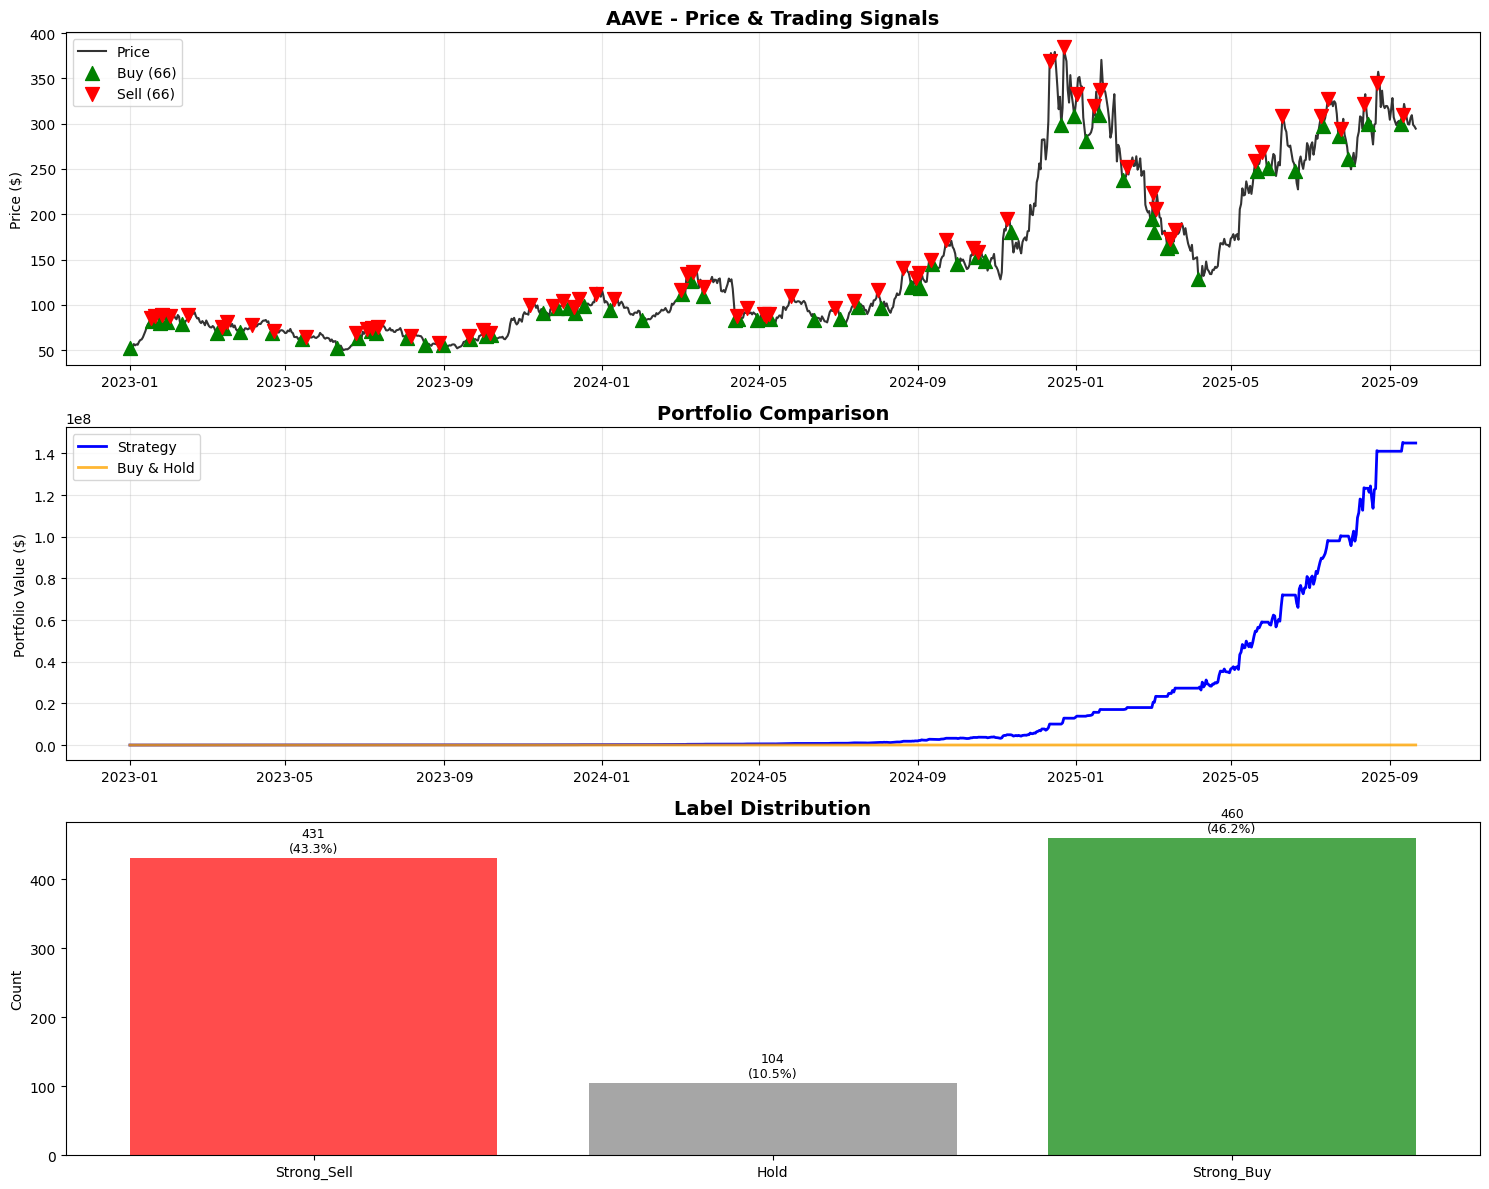

백테스팅:  33%|███▎      | 1/3 [00:00<00:01,  1.92it/s]


🪙 ADA 백테스팅 결과
📈 전략 수익률: 687611.22%
📊 Buy & Hold: 254.43%
⚡ 초과수익률: 687356.79%
📐 샤프 비율: 4.888
📉 최대손실폭: -11.85%
🔄 거래 횟수: 124회
🎯 승률: 100.00%
💵 최종 자산: $68,771,122
📅 기간: 2023-01-01 ~ 2025-09-21


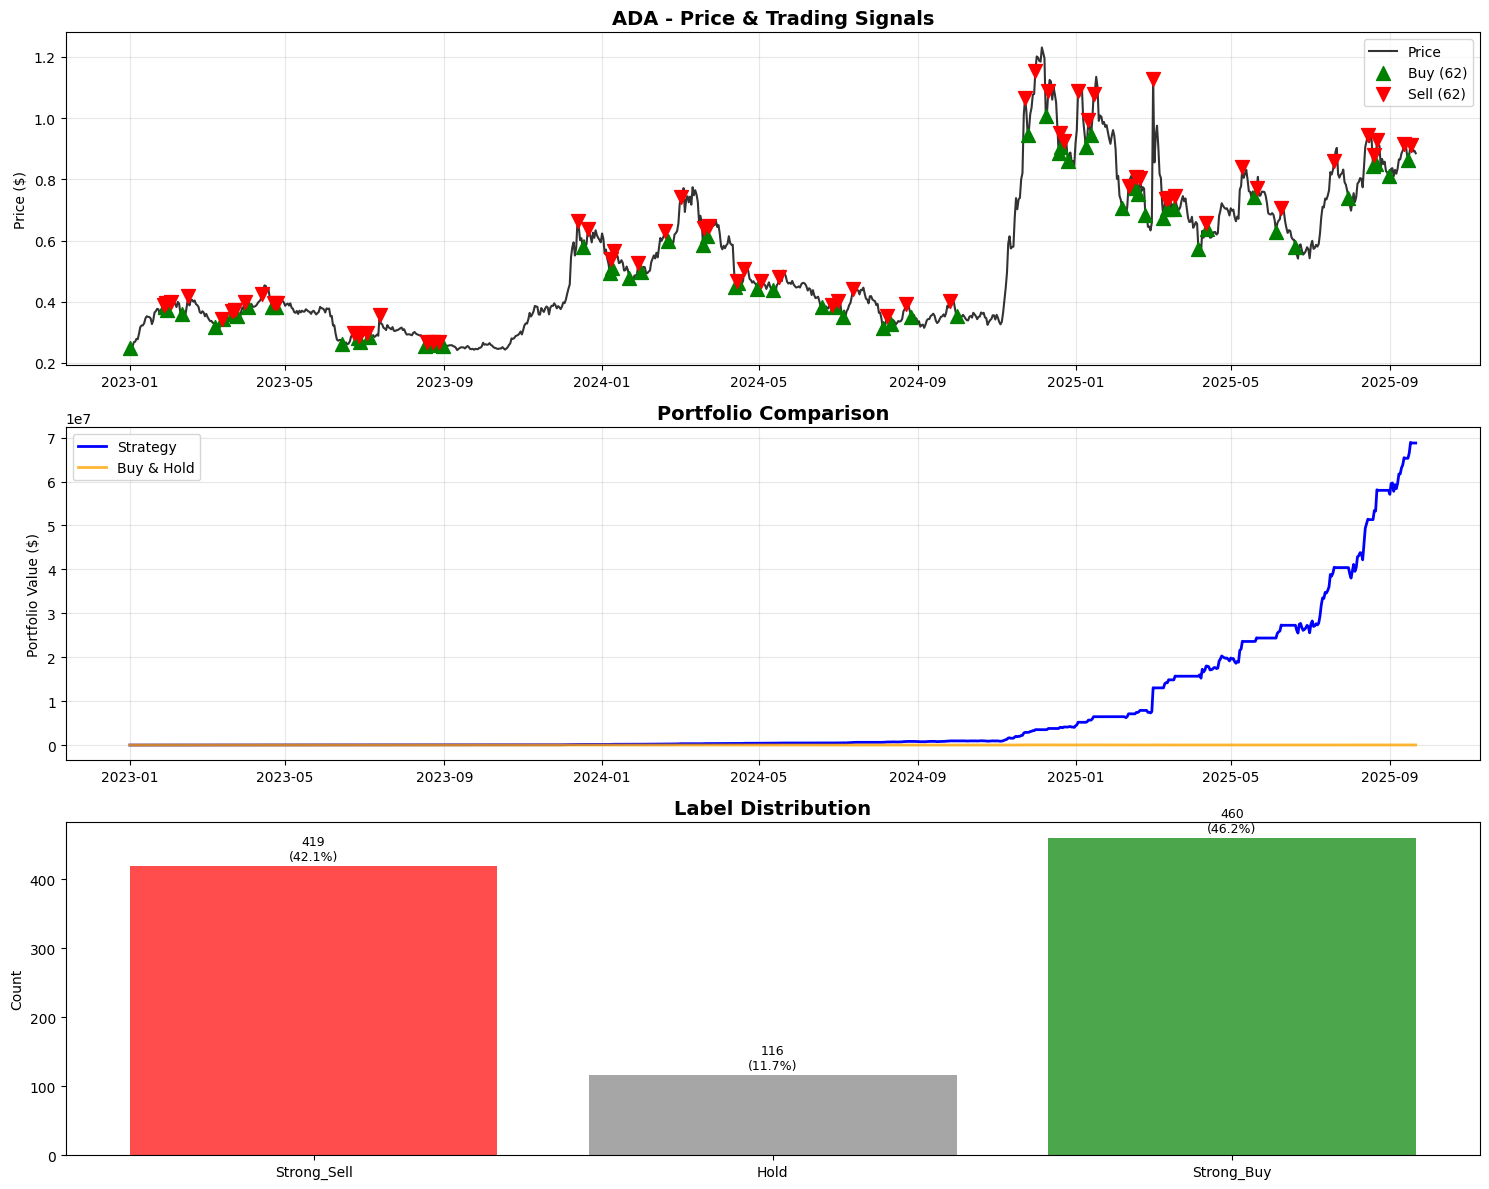

백테스팅:  67%|██████▋   | 2/3 [00:01<00:00,  1.92it/s]


🪙 AETHWETH 백테스팅 결과
📈 전략 수익률: 262.66%
📊 Buy & Hold: 78.60%
⚡ 초과수익률: 184.05%
📐 샤프 비율: 7.161
📉 최대손실폭: -7.99%
🔄 거래 횟수: 24회
🎯 승률: 91.67%
💵 최종 자산: $36,266
📅 기간: 2025-05-12 ~ 2025-09-21


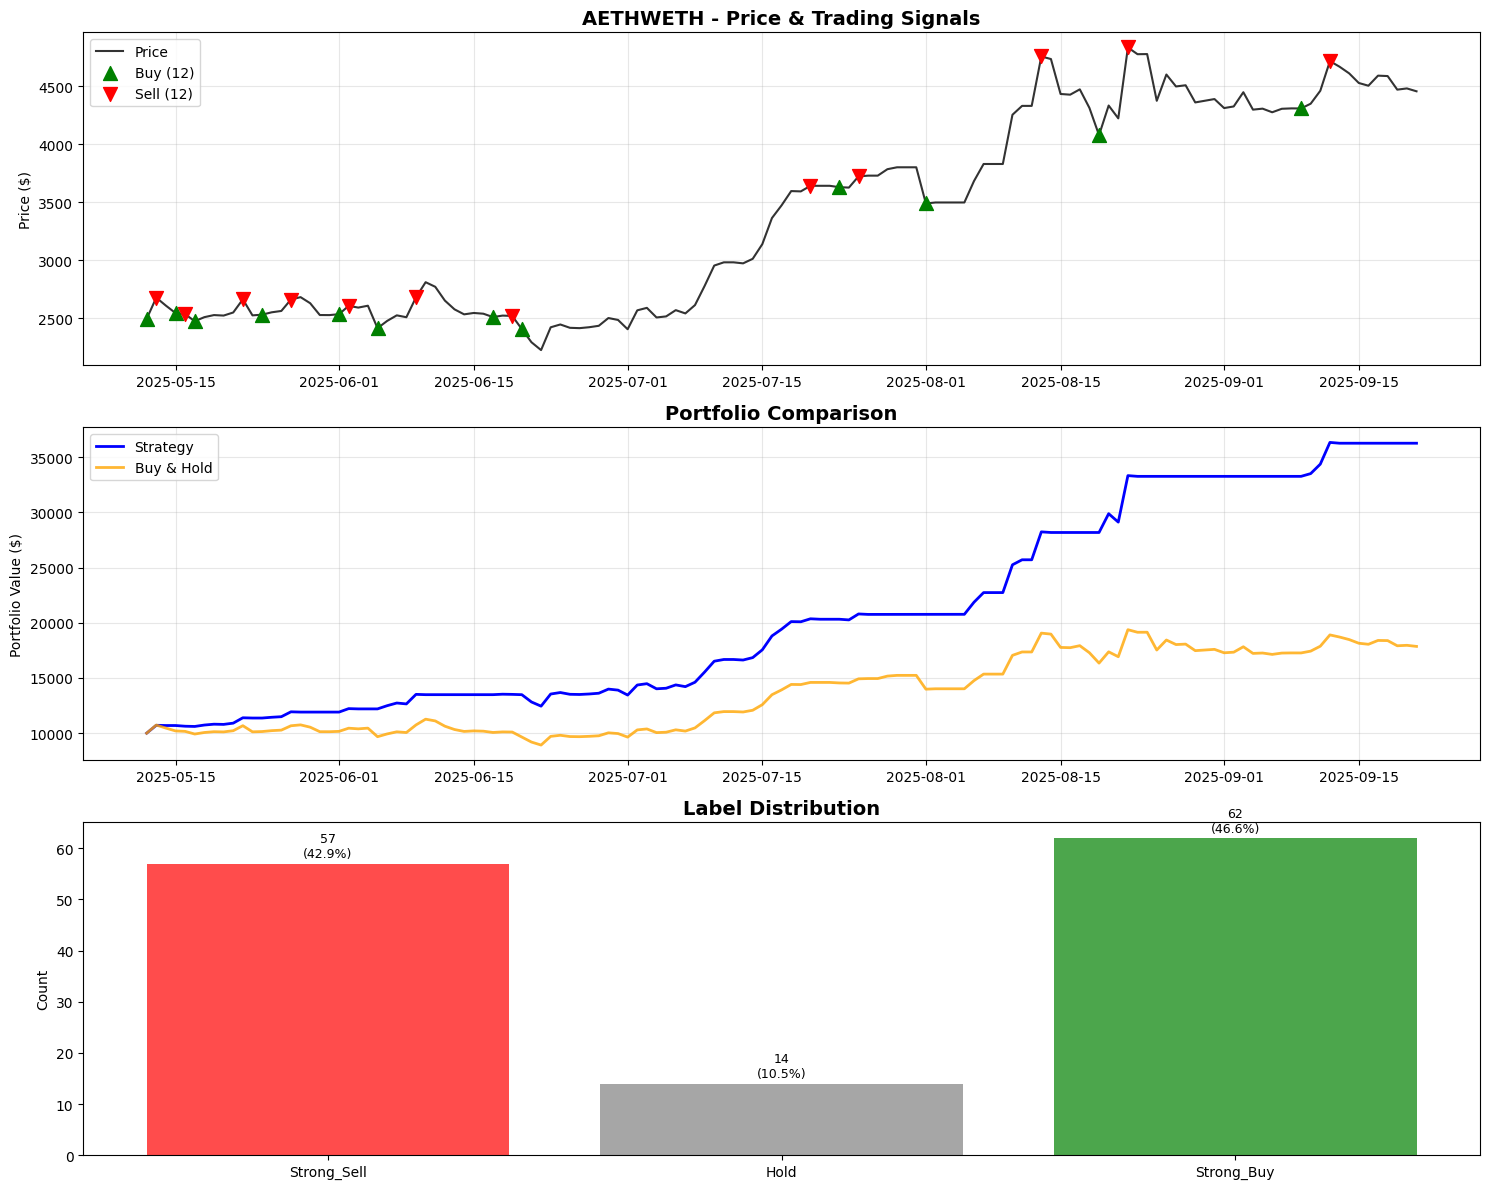

백테스팅: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


🚀 전체 백테스팅 결과 요약
  Symbol  Total_Return  Buy_Hold_Return  Excess_Return  Sharpe_Ratio  Max_Drawdown  Win_Rate  Num_Trades
    AAVE    14500.9195           4.6588     14496.2607        5.5390       -0.1796    1.0000         132
     ADA     6876.1122           2.5443      6873.5679        4.8880       -0.1185    1.0000         124
AETHWETH        2.6266           0.7860         1.8405        7.1608       -0.0799    0.9167          24

📊 평균 통계:
   평균 수익률: 712655.28%
   평균 초과수익률: 712388.97%
   평균 샤프비율: 5.863
   평균 승률: 97.22%


In [25]:

# 실행 코드
if __name__ == "__main__":
    save_path_1 = "/workspace/AI모델/projects/coin/data/v01/labeled"
    
    backtester, summary_df = run_individual_backtest(
        data_path=save_path_1,
        start_date='2023-01-01',
        end_date='2025-09-21',
        max_stocks=3,
        initial_capital=10000
    )

# 연도별 백테스팅 실행